In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from neuralprophet import NeuralProphet
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

c:\Miniconda3\envs\intern\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
df_week_2020_23 = pd.read_csv('./data/VolumeDataset_2020_to_2023.csv').drop('Unnamed: 0', axis=1)
df_daily_2021_23 = pd.read_csv('./data/data_dailly_2021_to_2023.csv')
df_monthly_2020_23 = pd.read_csv('./data/Month_clean_data.csv')
df_jan24_march24 = pd.read_excel('./data/data_jan24_March24.xlsx')
holidays_2020_23 = pd.read_csv('./data/holiday/holiday_2020.csv')

In [3]:
df_daily_2021_23.head()

,Date,A1,A2,E1,E2,N1,N2,N3,S1,S2,S3,W1,W2,W3,Cleared Volume,MCV
0,01-01-2021,605.02,1726.52,5337.17,468.38,21401.74,24508.57,2400.0,60931.20,9387.48,540.80,3249.30,35848.57,6105.0,172509.52,172509.52
1,02-01-2021,196.68,1564.11,5396.61,216.00,26037.07,28410.74,NaN,57619.45,13055.97,483.60,2261.28,40121.49,6360.0,181722.80,181722.80
2,03-01-2021,236.21,1798.70,4397.97,411.94,26628.81,27061.66,NaN,51113.54,13176.51,697.16,2672.50,46251.51,2715.0,177161.26,177161.26
3,04-01-2021,127.75,2009.93,4667.26,372.25,28270.30,15970.95,NaN,53456.41,15575.81,755.58,2702.25,59565.27,2225.0,185698.56,185698.56
4,05-01-2021,165.57,1833.25,4636.69,292.70,22619.43,22700.87,NaN,64673.62,15496.28,677.17,2643.65,52591.89,1875.0,190205.91,190205.90


In [4]:
holidays_2020_23.rename(columns={'date':'Date'}, inplace=True)

In [5]:
df_daily_2021_23.Date = pd.to_datetime(df_daily_2021_23['Date'],format='%d-%m-%Y')
holidays_2020_23.rename(columns={'date':'Date'}, inplace=True)

In [6]:
# holidays_2020_23.loc['Date'] == df_daily_2021_23.Date[0]
is_holiday = []
for date in df_daily_2021_23.Date:
    for date2 in holidays_2020_23.Date[49:]:
        if date == date2:
            is_holiday.append(True)
            break
    else:
        is_holiday.append(False)


In [7]:
df_daily_2021_23['is_holiday'] = is_holiday

In [8]:
df_daily_2021_23.fillna(0.0, inplace=True)

### Removing Trend and Seasonality

In [9]:
# from scipy.signal import detrend

# detrended = detrend(df_daily_2021_23['E1'], type='constant')
# detrended = pd.Series(detrended, index=df_daily_2021_23.index)

# from statsmodels.tsa.tsatools import detrend

# detrended = detrend(df_daily_2021_23['E1'], order=2)


rolling_mean = df_daily_2021_23['E1'].rolling(window=60, center=True).mean()
detrended = df_daily_2021_23['E1'] - rolling_mean

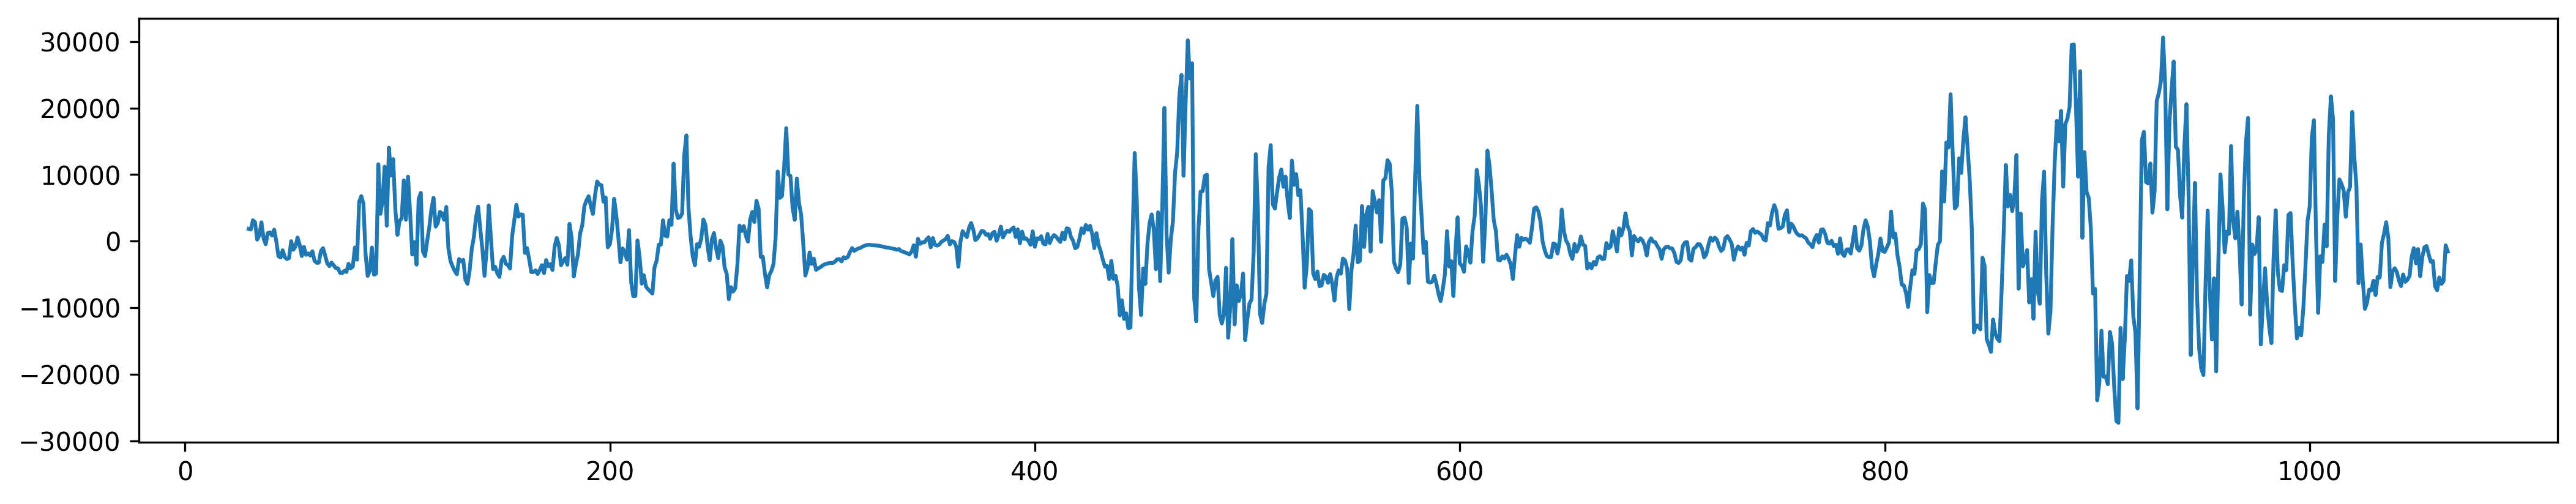

In [40]:
plt.plot(detrended)

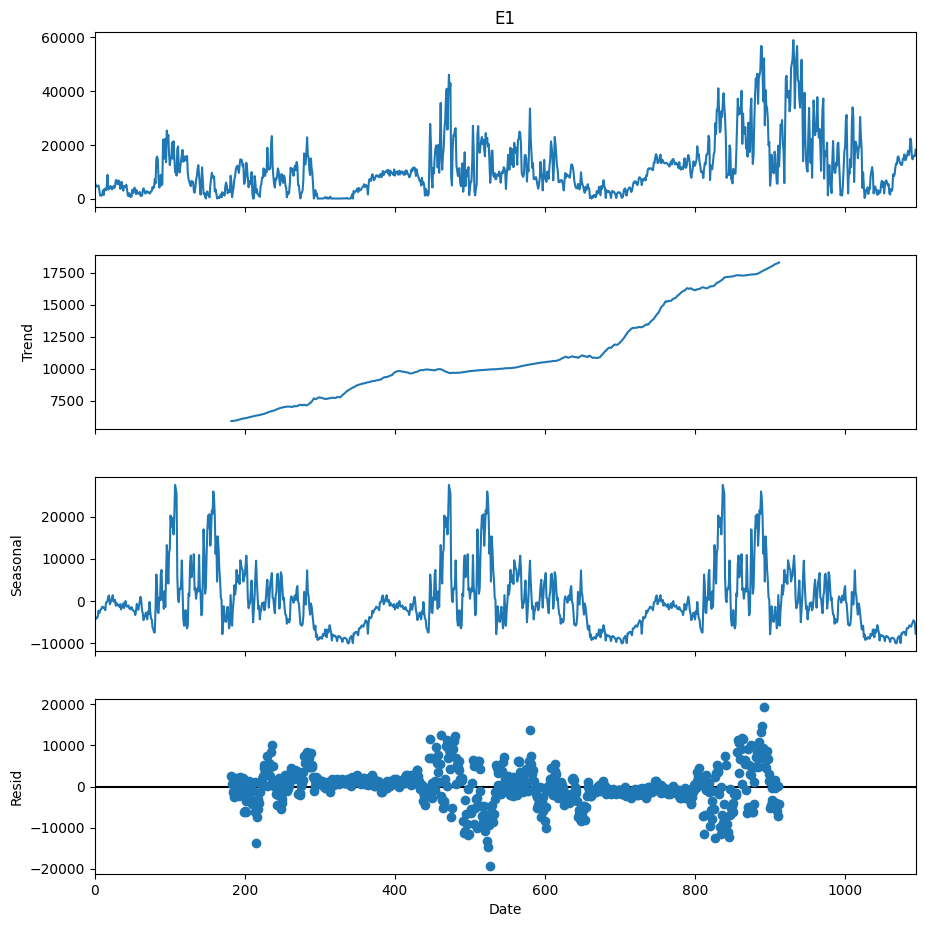

In [16]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic


# Decompose data by selecting the appropiate frequency
decomp = sm.tsa.seasonal_decompose(
  df_daily_2021_23['E1'], period=365)
decomp_plot = decomp.plot()

# Plot outcome
plt.xlabel('Date')
decomp_plot .set_figheight(10)
decomp_plot .set_figwidth(10)
plt.show()

In [12]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

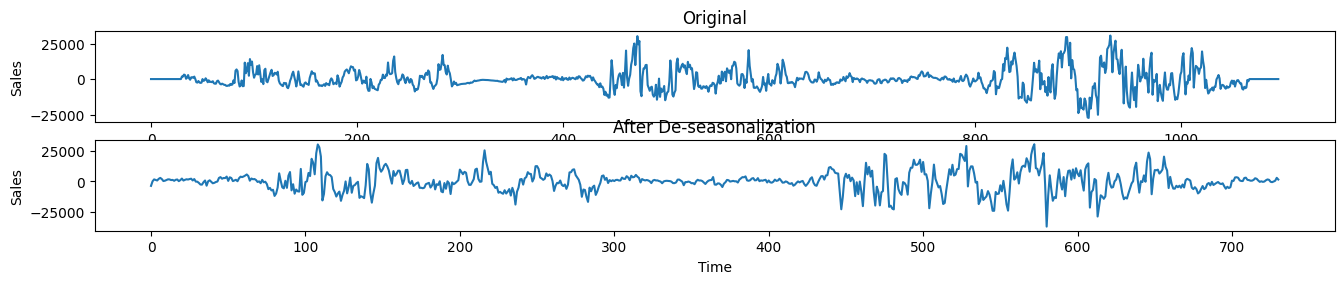

In [47]:
ts=detrended.fillna(0.0)
ts.astype('float')
plt.figure(figsize=(16,4))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
# plt.subplot(312)
# plt.title('After De-trend')
# plt.xlabel('Time')
# plt.ylabel('Sales')
# new_ts=difference(ts)
# plt.plot(new_ts)
# plt.plot()

plt.subplot(312)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,364)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

## Test stationarity

In [37]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                -8.506862e+00
p-value                        1.196383e-13
#Lags Used                     1.400000e+01
Number of Observations Used    7.160000e+02
Critical Value (1%)           -3.439516e+00
Critical Value (5%)           -2.865585e+00
Critical Value (10%)          -2.568924e+00
dtype: float64


In [48]:
print(len(new_ts))

new_ts = pd.concat([pd.Series([0.00]*182), new_ts, pd.Series([0.00]*182)])
new_ts.reset_index(drop=True, inplace=True)

731


In [52]:
new_ts

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1090    0.0
1091    0.0
1092    0.0
1093    0.0
1094    0.0
Length: 1095, dtype: float64

In [53]:
e1_df = df_daily_2021_23[['Date', 'N2', 'is_holiday']]
e1_df['stationary'] = new_ts.fillna(0.00)
e1_df

,Date,E1,is_holiday,stationary
0,2021-01-01,5337.17,True,0.0
1,2021-01-02,5396.61,False,0.0
2,2021-01-03,4397.97,False,0.0
3,2021-01-04,4667.26,False,0.0
4,2021-01-05,4636.69,False,0.0
...,...,...,...,...
1090,2023-12-27,14631.52,False,0.0
1091,2023-12-28,15744.12,False,0.0
1092,2023-12-29,16012.12,False,0.0
1093,2023-12-30,15857.66,False,0.0


### Prediction

In [54]:
features = ['is_holiday']
label = 'stationary'
test_df = e1_df[e1_df['Date'] >= '2023-06-01']
train_df = e1_df[e1_df['Date'] < '2023-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [55]:
reg = XGBRegressor(n_estimators=2000, learning_rate=0.1)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:7622.62745	validation_1-rmse:682.10296
[1]	validation_0-rmse:7620.99553	validation_1-rmse:681.37744
[2]	validation_0-rmse:7619.67232	validation_1-rmse:682.06998
[3]	validation_0-rmse:7618.59948	validation_1-rmse:683.78146
[4]	validation_0-rmse:7617.72962	validation_1-rmse:686.19803
[5]	validation_0-rmse:7617.02436	validation_1-rmse:689.07633
[6]	validation_0-rmse:7616.45254	validation_1-rmse:692.23033
[7]	validation_0-rmse:7615.98900	validation_1-rmse:695.51991
[8]	validation_0-rmse:7615.61316	validation_1-rmse:698.84131
[9]	validation_0-rmse:7615.30850	validation_1-rmse:702.11919
[10]	validation_0-rmse:7615.06143	validation_1-rmse:705.30020
[11]	validation_0-rmse:7614.86118	validation_1-rmse:708.34809
[12]	validation_0-rmse:7614.69883	validation_1-rmse:711.23935
[13]	validation_0-rmse:7614.56724	validation_1-rmse:713.96035
[14]	validation_0-rmse:7614.46052	validation_1-rmse:716.50466
[15]	validation_0-rmse:7614.37403	validation_1-rmse:718.87123
[16]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [56]:
predictions = reg.predict(X_test)

In [57]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

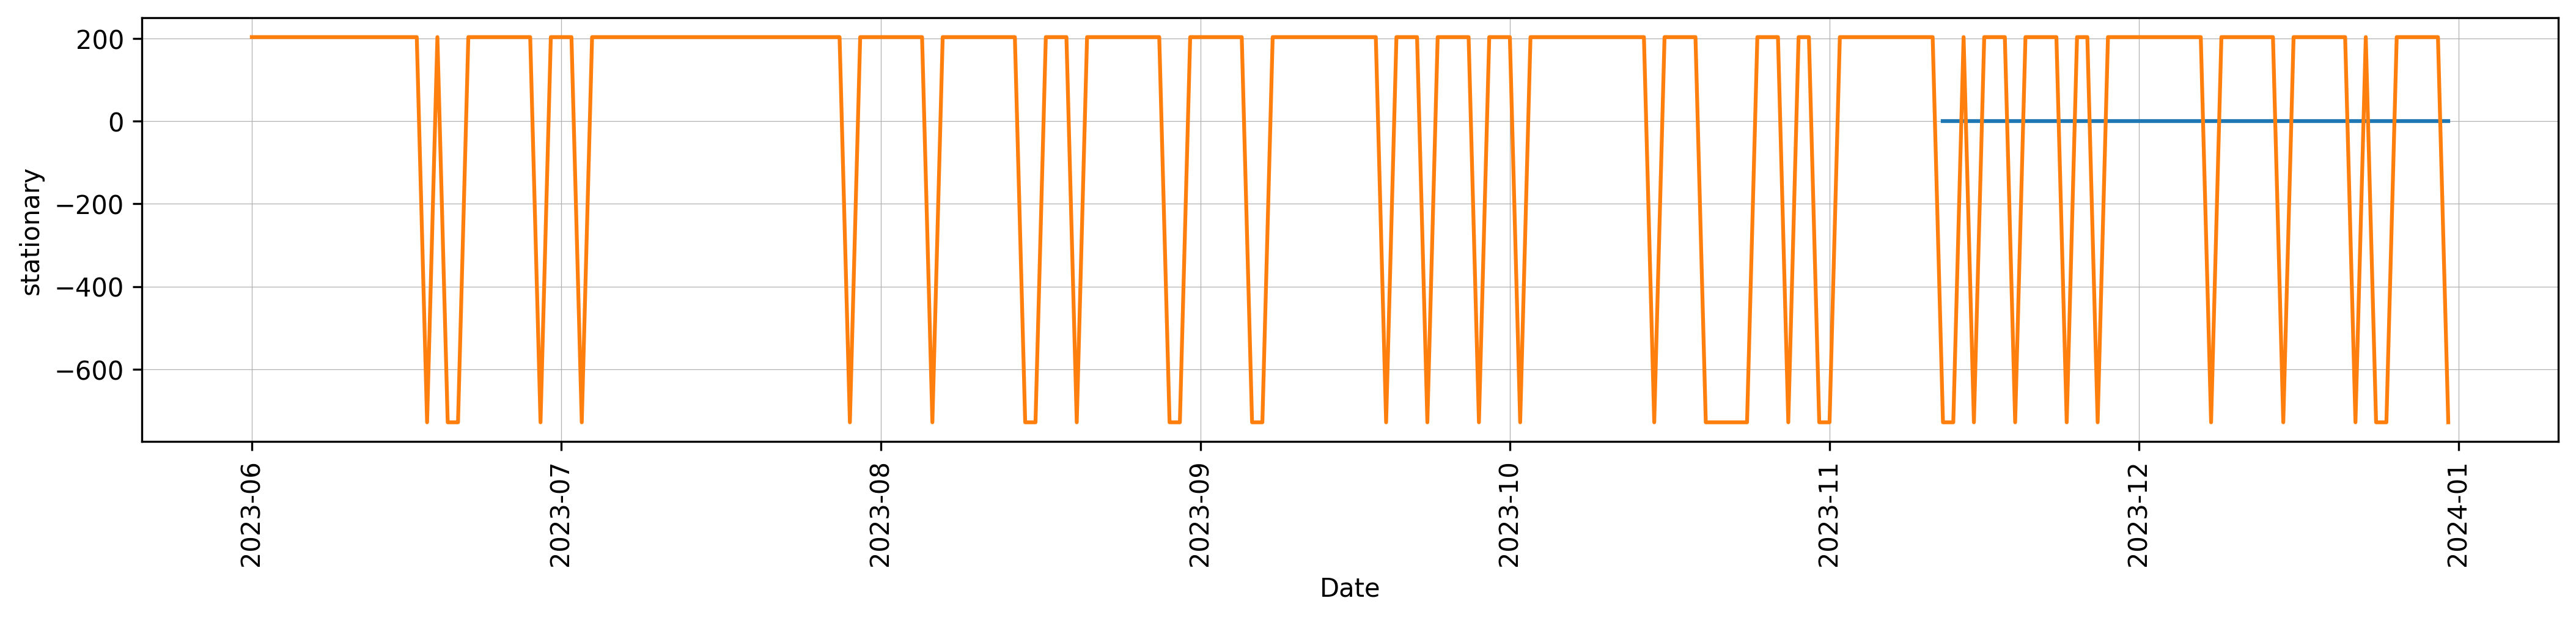

In [61]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=e1_df.tail(50), x='Date', y='stationary')
sns.lineplot(data=test_df, x='Date', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)